<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Thanks for taking the time to improve the project! It is now accepted. Good luck on the next sprint!

</div>

**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a pretty good job overall, but there are some issues that need to be fixed before the project is accepted. Let me know if you have questions!

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
%pip install pmdarima --user

Note: you may need to restart the kernel to use updated packages.


Note: I had to restart the kernel before getting the pmdarima library to work.

In [2]:
from pmdarima import auto_arima

In [98]:
# import libraries
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import arma_order_select_ic
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MaxAbsScaler

In [4]:
# load dataframe by parsing the time series
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
# display
display(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [6]:
data.info()
# 6 months

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
# make sure time series is in order
data.sort_index(inplace=True)

In [8]:
# Check if the time is monotonic
print(data.index.is_monotonic)

True


<div class="alert alert-success">
<b>Reviewer's comment</b>

Good idea to check that the time series is in correct order

</div>

In [9]:
# Check for nulls
data.isna().sum()

num_orders    0
dtype: int64

In [10]:
# check for duplicates
data[data.duplicated()]

,num_orders
datetime,
2018-03-01 02:10:00,12
2018-03-01 02:20:00,19
2018-03-01 03:00:00,8
2018-03-01 03:10:00,17
2018-03-01 03:20:00,7
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


The duplicates would make sense since they should be at different times.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Right!

</div>

In [11]:
print(data['num_orders'].unique())
print(data['num_orders'].nunique())

[  9  14  28  20  32  21   7   5  17  12  19  25  22   8   6   4  10  13
   2   3   0   1  11  15  16  23  18  33  24  26  30  38  34  42  31  27
  36  29  35  56  37  40  39  45  49  58  68  43  53  44  41  52  46  57
  47  64  61  50  48  55  62  54  71  78 119  99  51  60  87  90  94  82
  80  91  76  66  65  98  81  95  67]
81


In [12]:
data.value_counts()

num_orders
9             1373
11            1365
12            1317
10            1316
8             1253
              ... 
94               1
95               1
98               1
99               1
81               1
Length: 81, dtype: int64

In [13]:
# view the descriptive statistics
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


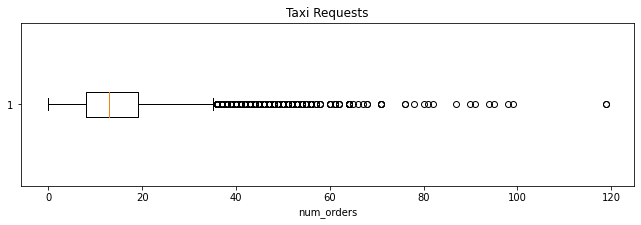

In [14]:
# Creating plot
plt.figure(figsize=(11, 3))
plt.boxplot(data, vert = 0)
plt.xlabel("num_orders")
plt.title("Taxi Requests")
#plt.figure(figsize=(8, 6))
# show plot
plt.show()

There appear to be many outliers. We will need to check the seasonality to see if there are repeating peaks.

Resampling the data for Sweet Lift Taxi company because they are looking at peak hours.

In [15]:
# Using the mean to resample by the hour
#data_hour = data.resample('1H').mean()
data_hour = data.resample('1H').sum()
decomposed = seasonal_decompose(data_hour)

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

We're looking to predict the total number of orders in an hour, not a mean value of orders in 10-minute intervals in an hour:)

</div>

<div class="alert alert-info">
  Changed the resampling to the sum instead of the mean.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Great!

</div>

In [16]:
display(data_hour)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


The data has been inspected and prepared.

## Analysis

We will check the decomposed graphs for trend, seasonality and residuals by the hour.

<AxesSubplot:xlabel='datetime'>

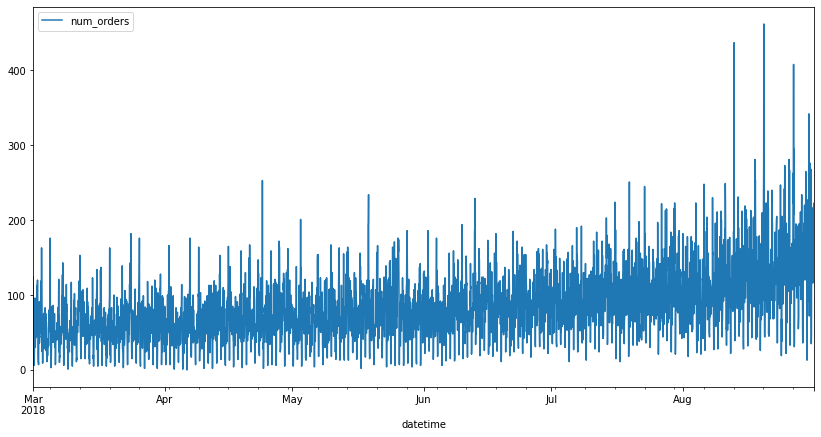

In [17]:
data_hour.plot(figsize=(14,7))

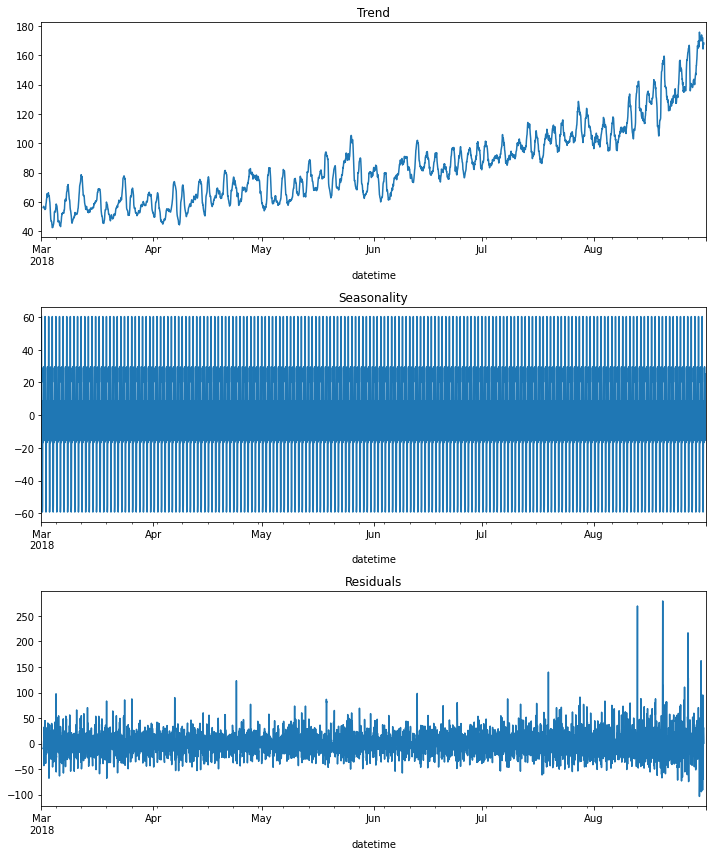

In [18]:
# Create the decomposed results
plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

In [19]:
# Now we'll look at a smaller period to get a better picture of the seasonality of the data
#data_week = data['2018-03-01':'2018-03-07'].resample('1H').sum()
#print(data_week)

<div class="alert alert-warning">
<b>Reviewer's comment</b>

It would make more sense to take a smaller slice of `decomposed.seasonal`, rather then decomposing the data for one week (how can we talk about any seasonality if we're looking at only one week's worth of data?)

</div>

<div class="alert alert-info">
  Made slices to the seasonal data below for better comparison.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Alright!

</div>

<AxesSubplot:xlabel='datetime'>

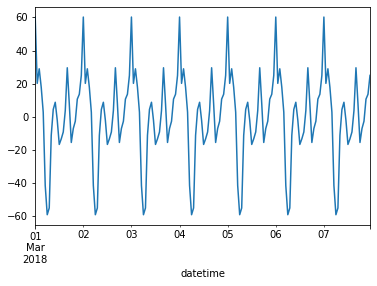

In [20]:
decomposed.seasonal['2018-03-01':'2018-03-07'].plot()

<AxesSubplot:xlabel='datetime'>

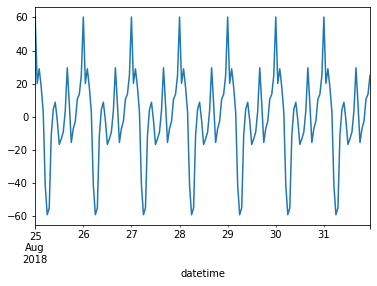

In [21]:
decomposed.seasonal['2018-08-25':'2018-08-31'].plot()

In [22]:
decomposed.seasonal

datetime
2018-03-01 00:00:00    60.248112
2018-03-01 01:00:00    20.177074
2018-03-01 02:00:00    28.982743
2018-03-01 03:00:00    17.885407
2018-03-01 04:00:00     2.791145
                         ...    
2018-08-31 19:00:00    -7.124270
2018-08-31 20:00:00    -2.696560
2018-08-31 21:00:00    10.670243
2018-08-31 22:00:00    13.596814
2018-08-31 23:00:00    25.000503
Freq: H, Name: seasonal, Length: 4416, dtype: float64

In [23]:
#decomposed_week = seasonal_decompose(data_week)
#decomposed_week.seasonal.plot()

In [24]:
#decomposed_week.trend.plot()

In [25]:
#decomposed_week.resid.plot()

In [26]:
#data_week['roll_mean'] = data_week['num_orders'].rolling(7).mean()
#data_week.plot()


When we narrowed down our timeframe to a week, we saw that there is definitely seasonality in our data. The taxi orders peaked usually around midnight.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright, you explored the data and made some useful observations!

</div>

## Training

Train different models with different hyperparameters. The test sample should be 10% of the initial dataset.

In [27]:
train_all, test = train_test_split(data_hour, shuffle=False, test_size=0.1)
print(train_all.shape, test.shape)

(3974, 1) (442, 1)


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was split without shuffling

</div>

In [28]:
train, valid = train_test_split(train_all, shuffle=False, test_size=0.1)
print(train.shape, valid.shape)

(3576, 1) (398, 1)


<div class="alert alert-info">
  Created a validation set for training.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Awesome!

</div>

In [29]:
# run the adfuller test to check for stationarity
df_stationarityTest = adfuller(train_all, autolag='AIC')
print("P-value: ", df_stationarityTest[1])

P-value:  0.00073227305273638


This shows that the data is stationary.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great!

</div>

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


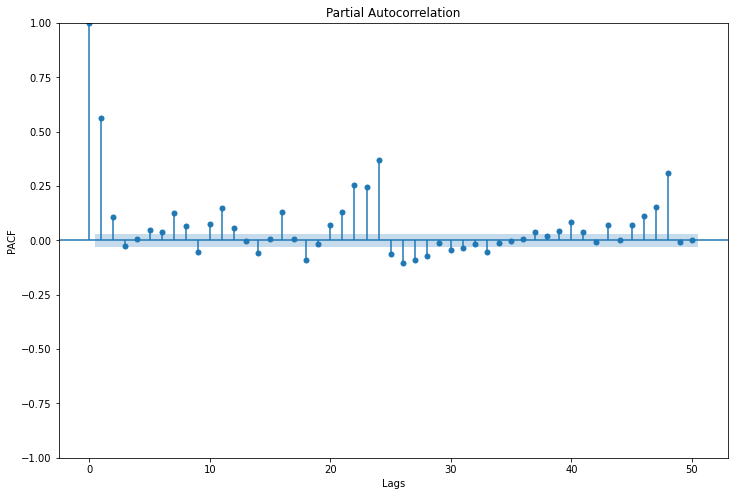

In [30]:
#plt.figure(figsize=(12, 8))

lags_to_check = 50
pacf = plot_pacf(x=train_all, lags=lags_to_check)  # fill in arguments here
pacf.set_figheight(8)
pacf.set_figwidth(12)
plt.xlabel("Lags")
plt.ylabel("PACF")
plt.show()

The pacf shows that the lags to use is 2.

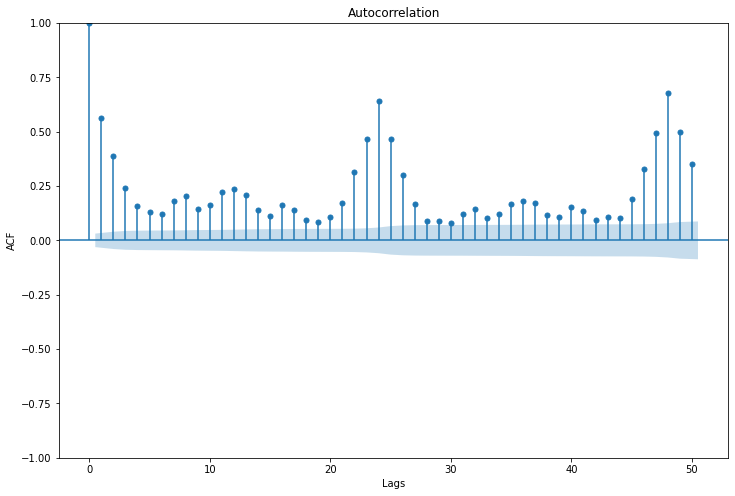

In [97]:
lags_to_check = 50
pacf = plot_acf(x=train_all, lags=lags_to_check)  # fill in arguments here
pacf.set_figheight(8)
pacf.set_figwidth(12)
plt.xlabel("Lags")
plt.ylabel("ACF")
plt.show()

### LinearRegression

In [31]:
train_lr = train.copy()
valid_lr = valid.copy()
test_lr = test.copy()
print(test_lr)  # train_lr)

                     num_orders
datetime                       
2018-08-13 14:00:00         102
2018-08-13 15:00:00         175
2018-08-13 16:00:00         144
2018-08-13 17:00:00         152
2018-08-13 18:00:00         104
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[442 rows x 1 columns]


In [32]:
# Create features function
def create_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hours'] = data.index.hour
    
    #data['lag_1'] = data['num_orders'].shift(1)
    #data['lag_2'] = data['num_orders'].shift(2)
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()
    feature_data = data.drop(['num_orders'], axis=1)
    target_data = data['num_orders']
    return feature_data, target_data

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Good job on feature engineering!

</div>

In [71]:
feature_train_lr, target_train_lr = create_features(train_lr, 24, 24)
print(feature_train_lr, target_train_lr)

                     year  month  day  dayofweek  hours  lag_1  lag_2  lag_3  \
datetime                                                                       
2018-03-02 00:00:00  2018      3    2          4      0   58.0  113.0   66.0   
2018-03-02 01:00:00  2018      3    2          4      1   90.0   58.0  113.0   
2018-03-02 02:00:00  2018      3    2          4      2  120.0   90.0   58.0   
2018-03-02 03:00:00  2018      3    2          4      3   75.0  120.0   90.0   
2018-03-02 04:00:00  2018      3    2          4      4   64.0   75.0  120.0   
...                   ...    ...  ...        ...    ...    ...    ...    ...   
2018-07-27 19:00:00  2018      7   27          4     19   76.0  160.0  162.0   
2018-07-27 20:00:00  2018      7   27          4     20   86.0   76.0  160.0   
2018-07-27 21:00:00  2018      7   27          4     21  131.0   86.0   76.0   
2018-07-27 22:00:00  2018      7   27          4     22  133.0  131.0   86.0   
2018-07-27 23:00:00  2018      7   27   

In [72]:
feature_valid_lr, target_valid_lr = create_features(valid_lr, 24, 24)
print(feature_valid_lr, target_valid_lr)

                     year  month  day  dayofweek  hours  lag_1  lag_2  lag_3  \
datetime                                                                       
2018-07-29 00:00:00  2018      7   29          6      0  120.0   92.0  140.0   
2018-07-29 01:00:00  2018      7   29          6      1  165.0  120.0   92.0   
2018-07-29 02:00:00  2018      7   29          6      2  102.0  165.0  120.0   
2018-07-29 03:00:00  2018      7   29          6      3  136.0  102.0  165.0   
2018-07-29 04:00:00  2018      7   29          6      4  101.0  136.0  102.0   
...                   ...    ...  ...        ...    ...    ...    ...    ...   
2018-08-13 09:00:00  2018      8   13          0      9   91.0   39.0   66.0   
2018-08-13 10:00:00  2018      8   13          0     10  137.0   91.0   39.0   
2018-08-13 11:00:00  2018      8   13          0     11  156.0  137.0   91.0   
2018-08-13 12:00:00  2018      8   13          0     12  144.0  156.0  137.0   
2018-08-13 13:00:00  2018      8   13   

In [73]:
feature_test_lr, target_test_lr = create_features(test_lr, 24, 24)
print(feature_test_lr, target_test_lr)

                     year  month  day  dayofweek  hours  lag_1  lag_2  lag_3  \
datetime                                                                       
2018-08-14 14:00:00  2018      8   14          1     14   64.0  114.0  162.0   
2018-08-14 15:00:00  2018      8   14          1     15  112.0   64.0  114.0   
2018-08-14 16:00:00  2018      8   14          1     16  116.0  112.0   64.0   
2018-08-14 17:00:00  2018      8   14          1     17  111.0  116.0  112.0   
2018-08-14 18:00:00  2018      8   14          1     18  152.0  111.0  116.0   
...                   ...    ...  ...        ...    ...    ...    ...    ...   
2018-08-31 19:00:00  2018      8   31          4     19  207.0  217.0  197.0   
2018-08-31 20:00:00  2018      8   31          4     20  136.0  207.0  217.0   
2018-08-31 21:00:00  2018      8   31          4     21  154.0  136.0  207.0   
2018-08-31 22:00:00  2018      8   31          4     22  159.0  154.0  136.0   
2018-08-31 23:00:00  2018      8   31   

In [ ]:
# Features for Test set
# test_lr = test.copy()
# test_lr['year'] = test_lr.index.year
# test_lr['month'] = test_lr.index.month
# test_lr['day'] = test_lr.index.day
# test_lr['dayofweek'] = test_lr.index.dayofweek
# test_lr['hours'] = test_lr.index.hour
# test_lr['lag_1'] = test_lr['num_orders'].shift(1)
# test_lr['lag_2'] = test_lr['num_orders'].shift(2)
# test_lr['rolling_mean'] = test_lr['num_orders'].shift().rolling(7).mean()
# test_lr = test_lr.dropna()

In [ ]:
# feature_train_lr = train_lr.drop(['num_orders'], axis=1)
# target_train_lr = train_lr['num_orders']
# print(feature_train_lr)
# print(target_train_lr.shape)

In [ ]:
# Scaling data sets
# scaler = MaxAbsScaler()
# scaler.fit(feature_train_lr)
# feature_train_lr = scaler.transform(feature_train_lr)
# print(feature_train_lr)

In [ ]:
# scaler = MaxAbsScaler()
# scaler.fit(feature_train_lr)
# feature_valid_lr = scaler.transform(feature_valid_lr)
# print(feature_valid_lr)

In [ ]:
# scaler = MaxAbsScaler()
# scaler.fit(feature_train_lr)
# feature_test_lr = scaler.transform(feature_test_lr)
# print(feature_test_lr)

<div class="alert alert-warning">
<b>Reviewer's comment V2</b>

Note that if you want to apply scaling, the same scaler fitted on the train set should be applied to validation and test sets as well

</div>

In [74]:
model_lr = LinearRegression()
model_lr.fit(feature_train_lr, target_train_lr)
predict_lr = model_lr.predict(feature_valid_lr)
#print(predict_lr)
lr_mse_val = mean_squared_error(target_valid_lr, predict_lr)
print(lr_mse_val**0.5)  # 40.51389934320261 no scaler ; w/ maxabsscaler 52.09222002492444

34.135414700079366


In [ ]:
# 40.36210044638575 @ 3 lags; 40.85702350774111 @ 24 roll; 40.623924609297674 @ 5, 24; 40.12970007661318 @ 12,12
# 40.17809996406857 @ 12, 24; 34.135414700079366 @ 24,24

### AutoReg

In [103]:
# scaler = MaxAbsScaler()
# scaler.fit(train)
# train_scaled = scaler.transform(train)
# print(train_scaled)
# valid_scaled = scaler.transform(valid)
# print(len(valid_scaled))

In [104]:
# df_train_scaled = pd.DataFrame(train_scaled, index=train.index, columns=['num_orders'])
# df_train_scaled

In [105]:
# df_valid_scaled = pd.DataFrame(valid_scaled, index=valid.index)
# df_valid_scaled

In [89]:
for i in range(20, 31):
    # find optimal number of lags
    mod = ar_select_order(endog=train, maxlag=i)  # df_train_scaled
    ar_order = mod.ar_lags
    # print(ar_order)
    # create AR model and fit it using the training set
    ar_model = AutoReg(train, lags=ar_order, seasonal=True)  # df_train_scaled
    ar_model = ar_model.fit()

    # make predictions
    start_value = len(train)  # df_train_scaled
    end_value = len(train) + len(valid) - 1  # df_train_scaled
    ar_pred = ar_model.predict(start=start_value, end=end_value, dynamic=True)

    # evaluate model
    ar_mse_value = mean_squared_error(valid, ar_pred) # calculate MSE   # df_train_scaled
    print(i, ':', ar_mse_value**0.5)   # maxlag=24  44.26447543767068 no scale; 

20 : 46.27164480183786
21 : 46.07442642815682
22 : 45.75188582174972
23 : 45.690053162919206
24 : 44.26447543767068
25 : 44.6449193672269
26 : 44.97283730922124
27 : 44.861516742999775
28 : 45.067834469209686
29 : 45.067834469209686
30 : 45.067834469209686


### auto_arima

In [106]:
model = auto_arima(train, seasonal=True, m=7, scoring='mse', error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5)  # df_train_scaled max_p=1, max_q=1, 

model.summary()  # Best model:  ARIMA(5,1,3)(2,0,0)[7] intercept Total fit time: 312.934 seconds
# make predictions
#predictions = model.predict(len(df_valid_scaled))

# evaluate the model predictions
#auto_arima_mse = mean_squared_error(df_valid_scaled, predictions)
#print(auto_arima_mse**0.5)  # 58.0112387752594 @ 1; 46.19702866457665 @ 7; failed @ 12

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=34416.593, Time=7.06 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=35505.914, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=35127.145, Time=2.89 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=34975.878, Time=3.69 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=35503.914, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=34404.706, Time=6.93 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=34404.328, Time=2.51 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=34407.417, Time=5.69 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=34601.340, Time=2.11 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=34649.261, Time=1.29 sec
 ARIMA(3,1,2)(0,0,0)[7] intercept   : AIC=34801.376, Time=2.72 sec
 ARIMA(2,1,3)(0,0,0)[7] intercept   : AIC=34440.077, Time=3.90 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=34556.038, Time=1.22 sec
 ARIMA(1,1,3)(0,0,0)[7] intercept   : AIC=34411.558, Time=3.37 sec
 ARIMA(3,1,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3576
Model:             SARIMAX(5, 1, 3)x(2, 0, [], 7)   Log Likelihood              -17155.700
Date:                            Mon, 01 Apr 2024   AIC                          34335.399
Time:                                    22:34:08   BIC                          34409.580
Sample:                                03-01-2018   HQIC                         34361.845
                                     - 07-27-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0189      0.014      1.317      0.188      -0.009       0.047
ar.L1          0.0511      0.322      0.159      0.874      -0.579       0.681
ar.L2         -0.3323      0.427     -0.778      0.437      -1.170       0.505
ar.L3          0.1808      0.162      1.118      0.264      -0.136       0.498
ar.L4          0.0118      0.047      0.250      0.803      -0.081       0.104
ar.L5         -0.0884      0.036     -2.431      0.015      -0.160      -0.017
ma.L1         -0.6285      0.323     -1.949      0.051      -1.261       0.004
ma.L2          0.2163      0.524      0.413      0.680      -0.811       1.243
ma.L3         -0.5664      0.392     -1.444      0.149      -1.335       0.203
ar.S.L7        0.0045      0.025      0.177      0.860      -0.045       0.054
ar.S.L14      -0.0880      0.021     -4.129      0.000      -0.130      -0.046
sigma2       946.5580     21.648     43.724      0.000     904.128     988.988
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):               394.67
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [107]:
predictions = model.predict(n_periods = len(valid))
mean_squared_error(valid, predictions)**0.5

46.217425948563886

In [81]:
model_aa = auto_arima(train, start_p=5, d=1, start_q=3, max_p=5, max_d=1, max_q=3,
                   seasonal=True, m=7, scoring='mse', error_action='ignore', trace=True,
                   suppress_warnings=True, maxiter=5)

model_aa.summary()

Performing stepwise search to minimize aic
 ARIMA(5,1,3)(1,0,1)[7] intercept   : AIC=34356.921, Time=10.73 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=35505.914, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=35127.145, Time=3.22 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=34975.878, Time=2.88 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=35503.914, Time=0.10 sec
 ARIMA(5,1,3)(0,0,1)[7] intercept   : AIC=34357.077, Time=8.80 sec
 ARIMA(5,1,3)(1,0,0)[7] intercept   : AIC=34357.547, Time=12.01 sec
 ARIMA(5,1,3)(2,0,1)[7] intercept   : AIC=34340.800, Time=16.65 sec
 ARIMA(5,1,3)(2,0,0)[7] intercept   : AIC=34335.399, Time=15.99 sec
 ARIMA(4,1,3)(2,0,0)[7] intercept   : AIC=34373.540, Time=18.50 sec
 ARIMA(5,1,2)(2,0,0)[7] intercept   : AIC=34674.451, Time=16.20 sec
 ARIMA(4,1,2)(2,0,0)[7] intercept   : AIC=34709.484, Time=14.79 sec
 ARIMA(5,1,3)(2,0,0)[7]             : AIC=34336.203, Time=10.87 sec

Best model:  ARIMA(5,1,3)(2,0,0)[7] intercept
Total fit time: 130.872 seconds

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3576
Model:             SARIMAX(5, 1, 3)x(2, 0, [], 7)   Log Likelihood              -17155.700
Date:                            Mon, 01 Apr 2024   AIC                          34335.399
Time:                                    21:30:42   BIC                          34409.580
Sample:                                03-01-2018   HQIC                         34361.845
                                     - 07-27-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0189      0.014      1.317      0.188      -0.009       0.047
ar.L1          0.0511      0.322      0.159      0.874      -0.579       0.681
ar.L2         -0.3323      0.427     -0.778      0.437      -1.170       0.505
ar.L3          0.1808      0.162      1.118      0.264      -0.136       0.498
ar.L4          0.0118      0.047      0.250      0.803      -0.081       0.104
ar.L5         -0.0884      0.036     -2.431      0.015      -0.160      -0.017
ma.L1         -0.6285      0.323     -1.949      0.051      -1.261       0.004
ma.L2          0.2163      0.524      0.413      0.680      -0.811       1.243
ma.L3         -0.5664      0.392     -1.444      0.149      -1.335       0.203
ar.S.L7        0.0045      0.025      0.177      0.860      -0.045       0.054
ar.S.L14      -0.0880      0.021     -4.129      0.000      -0.130      -0.046
sigma2       946.5580     21.648     43.724      0.000     904.128     988.988
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):               394.67
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
# make predictions
predictions = model_aa.predict(len(valid))

# evaluate the model predictions
auto_arima_mse = mean_squared_error(valid, predictions)
print(auto_arima_mse**0.5)  # 46.217425948563886

46.217425948563886


### ARIMA

In [91]:
model_arima = ARIMA(train, order=(5,1,3))
model_arima = model_arima.fit()
# make predictions
start_value = len(train)  # df_train_scaled
end_value = len(train) + len(valid) - 1  # df_train_scaled
#ar_pred = ar_model.predict(start=start_value, end=end_value, dynamic=False)
arima_predict = model_arima.predict(start=start_value, end=end_value, dynamic=False)

print(arima_predict)

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2018-07-28 00:00:00    133.315018
2018-07-28 01:00:00    104.805945
2018-07-28 02:00:00     90.548960
2018-07-28 03:00:00     88.622570
2018-07-28 04:00:00    106.362776
                          ...    
2018-08-13 09:00:00    104.233012
2018-08-13 10:00:00    104.233012
2018-08-13 11:00:00    104.233012
2018-08-13 12:00:00    104.233012
2018-08-13 13:00:00    104.233012
Freq: H, Name: predicted_mean, Length: 398, dtype: float64


In [94]:
arima_mse = mean_squared_error(valid, arima_predict)
print(arima_mse**0.5)

46.707991057406616


### SARIMAX

In [99]:
model_sarimax = SARIMAX(train, order=(5,1,3), seasonal_order=(2,0,0,7))
model_sarimax = model_sarimax.fit()
# make predictions
start_value = len(train)  # df_train_scaled
end_value = len(train) + len(valid) - 1  # df_train_scaled

sarimax_predict = model_sarimax.predict(start=start_value, end=end_value, dynamic=False)
print(sarimax_predict)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.81433D+00    |proj g|=  6.73847D-02


 This problem is unconstrained.



At iterate    5    f=  4.79785D+00    |proj g|=  3.47672D-03

At iterate   10    f=  4.79643D+00    |proj g|=  2.57544D-02

At iterate   15    f=  4.78913D+00    |proj g|=  1.93806D-02

At iterate   20    f=  4.78736D+00    |proj g|=  1.38536D-02

At iterate   25    f=  4.78425D+00    |proj g|=  7.05427D-03

At iterate   30    f=  4.78407D+00    |proj g|=  6.72375D-03

At iterate   35    f=  4.78377D+00    |proj g|=  6.77171D-03

At iterate   40    f=  4.78347D+00    |proj g|=  1.49084D-02

At iterate   45    f=  4.78304D+00    |proj g|=  5.21739D-03


/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.78282D+00    |proj g|=  4.91253D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     68      1     0     0   4.913D-03   4.783D+00
  F =   4.7828215035011494     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
2018-07-28 00:00:00    130.157918
2018-07-28 01:00:00    105.131756
2018-07-28 02:00:00     90.333059
2018-07-28 03:00:00     86.975636
2018-07-28 04:00:00    106.802277
                          ...    
2018-08-13 09:00:00    104.285249
2018-08-13 10:00:00    104.285249
2018-08-13 11:00:00    104.285249
2018-08-13 12:00:00    104.285249
2018-08-13 13:00:00  

In [100]:
sarimax_mse = mean_squared_error(valid, sarimax_predict)
print(sarimax_mse**0.5)

46.69035130455062


All the models achieved a RMSE score below 48 on the validation set.

## Testing

The RMSE metric on the test set should not be more than 48.

In [75]:
feature_train_linreg = pd.concat([feature_train_lr, feature_valid_lr])

target_train_linreg = pd.concat([target_train_lr, target_valid_lr])
feature_train_linreg.shape
#target_train_linreg

(3926, 30)

In [76]:
model_lr = LinearRegression()
model_lr.fit(feature_train_lr, target_train_lr)
predict_lr = model_lr.predict(feature_test_lr)
lr_mse_val = mean_squared_error(target_test_lr, predict_lr)
print(lr_mse_val**0.5)  # 

46.32453535485391


In [77]:
# 53.9665039683576 @ 3 lags; 52.4117501263748 @ 24 roll; 52.180901032100245 @ 5, 24; 53.438835006494436 @ 12,12
# 52.19143565124224 @ 12,24; 46.32453535485391 @ 24,24

In [90]:
# AutoReg Testing
# find optimal number of lags
mod = ar_select_order(endog=train_all, maxlag=24)  # train_ar_arima
ar_order = mod.ar_lags

# create AR model and fit it using the training set
ar_model = AutoReg(train_all, lags=ar_order, seasonal=True)  # train_ar_arima
ar_model = ar_model.fit()

# make predictions
start_value = len(train_all)  # train_ar_arima
end_value = len(train_all) + len(test) - 1  # train_ar_arima
ar_pred = ar_model.predict(start=start_value, end=end_value, dynamic=True)

# evaluate model
ar_mse_value = mean_squared_error(test, ar_pred) # calculate MSE
print(ar_mse_value**0.5)  
# 68.92728379869911 train_all

68.92728379869911


In [95]:
model_arima = ARIMA(train_all, order=(5,1,3))
model_arima = model_arima.fit()
# make predictions
start_value = len(train_all)  # df_train_scaled
end_value = len(train_all) + len(test) - 1  # df_train_scaled
#ar_pred = ar_model.predict(start=start_value, end=end_value, dynamic=False)
arima_predict = model_arima.predict(start=start_value, end=end_value, dynamic=False)

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [96]:
arima_mse = mean_squared_error(test, arima_predict)
print(arima_mse**0.5)

64.6518044890887


In [101]:
model_sarimax = SARIMAX(train_all, order=(5,1,3), seasonal_order=(2,0,0,7))
model_sarimax = model_sarimax.fit()
# make predictions
start_value = len(train_all)  # df_train_scaled
end_value = len(train_all) + len(test) - 1  # df_train_scaled

sarimax_predict = model_sarimax.predict(start=start_value, end=end_value, dynamic=False)
#print(sarimax_predict)
sarimax_mse = mean_squared_error(test, sarimax_predict)
print(sarimax_mse**0.5)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.85683D+00    |proj g|=  7.05943D-02

At iterate    5    f=  4.84091D+00    |proj g|=  5.90226D-03

At iterate   10    f=  4.83922D+00    |proj g|=  3.63665D-02

At iterate   15    f=  4.83189D+00    |proj g|=  1.74790D-02

At iterate   20    f=  4.83039D+00    |proj g|=  1.76350D-02

At iterate   25    f=  4.82634D+00    |proj g|=  2.21309D-02

At iterate   30    f=  4.82612D+00    |proj g|=  5.27477D-03

At iterate   35    f=  4.82582D+00    |proj g|=  3.63149D-03

At iterate   40    f=  4.82494D+00    |proj g|=  3.75415D-02

At iterate   45    f=  4.82464D+00    |proj g|=  7.88240D-03

At iterate   50    f=  4.82433D+00    |proj g|=  6.33905D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


64.865748534021


In [102]:
# auto_arima Testing
model = auto_arima(train_all, start_p=5, d=1, start_q=3, max_p=5, max_d=1, max_q=3,
                   seasonal=True, m=7, scoring='mse', error_action='ignore', trace=True,
                   suppress_warnings=True, maxiter=5)  

# make predictions
predictions = model.predict(len(test))

# evaluate the model predictions
auto_arima_mse = mean_squared_error(test, predictions)
print(auto_arima_mse**0.5)  # 60.697477945419294

Performing stepwise search to minimize aic
 ARIMA(5,1,3)(1,0,1)[7] intercept   : AIC=38523.718, Time=13.38 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=39785.522, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=39397.038, Time=3.70 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=39248.904, Time=4.01 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=39783.522, Time=0.13 sec
 ARIMA(5,1,3)(0,0,1)[7] intercept   : AIC=38524.497, Time=10.35 sec
 ARIMA(5,1,3)(1,0,0)[7] intercept   : AIC=38524.495, Time=13.62 sec
 ARIMA(5,1,3)(2,0,1)[7] intercept   : AIC=38505.575, Time=19.84 sec
 ARIMA(5,1,3)(2,0,0)[7] intercept   : AIC=38497.165, Time=18.70 sec
 ARIMA(4,1,3)(2,0,0)[7] intercept   : AIC=inf, Time=17.29 sec
 ARIMA(5,1,2)(2,0,0)[7] intercept   : AIC=38876.086, Time=17.41 sec
 ARIMA(4,1,2)(2,0,0)[7] intercept   : AIC=38928.783, Time=15.99 sec
 ARIMA(5,1,3)(2,0,0)[7]             : AIC=38497.514, Time=11.35 sec

Best model:  ARIMA(5,1,3)(2,0,0)[7] intercept
Total fit time: 145.913 seconds
60.6

The only model to achieve the benchmark under a RMSE value of 48 was the LinearRegression model with the number of lags at 24 and a rolling mean of 24.

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Great, you tried a couple of different models, but there are some problems here:
    
1. It is not appropriate to tune the model's hyperparameters using the test set. You need to use either a validation set or cross-validation with a [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)
    
2. You're calculating MAE instead of RMSE

3. You're doing a different problem than what the task asked for due to incorrect resampling :)
    
</div>

<div class="alert alert-warning">
<b>Reviewer's comment</b>

It would be nice if you tried doing some feature engineering from the time series yourself (e.g. calendar features, lag features, a shifted rolling mean) and training a linear regression model using those features

</div>

<div class="alert alert-info">

1. Split the training set into train and validation sets.

2. Updated MAE to RMSE, got confused with all the acronyms, heh.

3. Added features for the linear regression model.
    
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Ok, all looks good! :)

</div>

## Conclusion

Sweet Lift Taxi should use the LinearRegression model with the number of lags at 24 and a rolling mean of 24, even though the data is seasonal on a daily basis. When we looked at the data in a weeks time, we saw that the largest amount of taxi orders at the airport tended to spike at night around midnight.

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Please check the results after fixing the problems above

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Well done!

</div>

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48